In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from Shadow.ShadowPreprocessorsXraylib import prerefl, pre_mlayer, bragg
from pykern import pkjson
from pykern.pkcollections import PKDict
from pykern.pkdebug import pkdc, pkdp
from pykern import pkio
from sirepo.template import transfer_mat_bl
from srxraylib.sources import srfunc
import Shadow
import math
import numpy
import re
import scipy.linalg as sla

In [2]:
# from https://github.com/radiasoft/rslight/blob/main/Gaussian/gauss_apert-01.py

#  Propagate a 4x4 covariance matrix Sigma through a Gaussian aperture of (Gaussian, not not hard-edge)
#  size parameters a_gx, a_gy
#  NB:  assumed ordering of the variables is x, y, theta_x, theta_y
def gauss_apert_4x4(Sigma, lambda_rad, a_gx, a_gy):
    Sigma_inv = sla.inv(Sigma)
    A = 1.0 *Sigma_inv[0:2,0:2]
    B = 1.0 *Sigma_inv[0:2,2:4]
    C = numpy.transpose(B)
    D = 1.0 *Sigma_inv[2:4,2:4]

    A_A = numpy.zeros([2,2], dtype=numpy.float32)
    A_A[0,0] = 2. /a_gx**2
    A_A[1,1] = 2. /a_gy**2

    D_inv = sla.inv(D)
    D_A_inv = numpy.zeros([2,2], dtype=numpy.float32)
    D_A_inv[0,0] = 1. /a_gx**2
    D_A_inv[1,1] = 1. /a_gy**2
    D_A_inv *= lambda_rad**2 /(8. *numpy.pi *numpy.pi)

    D_f = sla.inv(D_inv +D_A_inv)
    BDi = numpy.matmul(B, D_inv)
    DiC = numpy.matmul(D_inv, C)  #  == numpy.transpose(BDi)
    C_f = numpy.matmul(D_f, DiC)
    B_f = numpy.transpose(C_f)    #  ==  numpy.matmul(BDi, D_f)
    A_f = A +A_A -numpy.matmul(BDi, C) +numpy.matmul(BDi, numpy.matmul(D_f, DiC))

    Sigma_inv[0:2,0:2] = 1.0 *A_f
    Sigma_inv[0:2,2:4] = 1.0 *B_f
    Sigma_inv[2:4,0:2] = 1.0 *C_f
    Sigma_inv[2:4,2:4] = 1.0 *D_f

    return sla.inv(Sigma_inv)

In [3]:
source = Shadow.Source()
beam = Shadow.Beam()
source.NPOINT = 10000
source.ISTAR1 = 567656

source.SIGMAX = 0.012526741356
source.SIGMAZ = 0.001341640786
source.EPSI_X = 5.500000000000001e-08
source.EPSI_Z = 8e-10
source.BENER = 3.0
source.EPSI_DX = 0.0
source.EPSI_DZ = 0.0
source.F_POL = 3
source.HDIV1 = 0.0005
source.HDIV2 = 0.0005
source.VDIV1 = 1.0
source.VDIV2 = 1.0
source.F_PHOT = 0
source.FSOURCE_DEPTH = 4
source.F_COLOR = 3
source.R_MAGNET = 25.0173071398614
source.PH1 = 2500.0
source.PH2 = 2500.001
source.FDISTR = 4
source.R_ALADDIN = source.R_MAGNET * 100
beam.genSource(source)
rays = beam.rays

 Generated          500  rays out of        10000
                   1000
                   1500
                   2000
                   2500
                   3000
                   3500
                   4000
                   4500
                   5000
                   5500
                   6000
                   6500
                   7000
                   7500
                   8000
                   8500
                   9000
                   9500
                  10000
 Exit from SOURCE


In [4]:
def rays_sigma(rays, idx):
    return numpy.sqrt(numpy.mean(rays[:, idx] ** 2))

sigmax = rays_sigma(rays, 0)
sigdix = rays_sigma(rays, 3)
sigmaz = rays_sigma(rays, 2)
sigdiz = rays_sigma(rays, 5)

beam_stats = []
epsilon = 1e-06
beam = transfer_mat_bl.create_mat_rays(epsilon, 2500.0)

sigma_mat = numpy.matrix([
    [sigmax ** 2, 0, 0, 0],
    [0, sigdix ** 2, 0, 0],
    [0, 0, sigmaz ** 2, 0],
    [0, 0, 0, sigdiz ** 2],
])
alpha = 0

Pmat = numpy.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]])

def apply_aperture(oe, mat):
    pkdp('aperture size [m]: {} x {}',
         oe.RX_SLIT[0] * 1e-2,
         oe.RZ_SLIT[0] * 1e-2)
    #pkdp('matrix  in: {}', numpy.matmul(numpy.matmul(Pmat, mat), Pmat))
    res = gauss_apert_4x4(
        # Convert Sigma to x, y, xp, yp, via Pmat Sigma Pmat (since Pmat is symmetric)
        numpy.matmul(numpy.matmul(Pmat, mat), Pmat),
        #TODO(pjm): parameter for this? wavelength in [m]
        1e-10,
        oe.RX_SLIT[0],
        oe.RZ_SLIT[0],
    )
    return numpy.matmul(numpy.matmul(Pmat, res), Pmat)

def assert_no_lost_rays(beam):
    lost = []
    LOST_RAY_FLAG = 9
    for i in range(len(beam.rays)):
        if beam.rays[i][LOST_RAY_FLAG] != 1:
            lost.append(i)
    if len(lost):
        raise AssertionError(
            'Lost tracking particle(s) # {}'.format(
                ', '.join(str(v) for v in lost)),
        )

def calculate_stats(pos, oe):
    global alpha
    global sigma_mat
    global beam
    Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
    res = Tmat * sigma_mat * numpy.transpose(Tmat)
    pos += (oe.T_SOURCE if oe else 0)
    if oe:
        # oe.ALPHA is in radians after traceOE()
        alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
    beam_stats.append(PKDict(
        isRotated=True if alpha == 90 or alpha == 270 else False,
        s=pos * 1e-2,
        x=x_prop_cen,
        xp=xp_prop_cen,
        z=z_prop_cen,
        zp=zp_prop_cen,
        matrix=Tmat.tolist(),
        sigma_mx=res.tolist(),
        sigmax=math.sqrt(res[0, 0]) * 1e-2,
        sigdix=math.sqrt(res[1, 1]),
        sigmaz=math.sqrt(res[2, 2]) * 1e-2,
        sigdiz=math.sqrt(res[3, 3]),
    ))
    if oe and oe.I_STOP[0] == 0 and oe.RX_SLIT[0] != 0 and oe.RZ_SLIT[0] != 0:
        res2 = apply_aperture(oe, res)
        pkdp('sigma_mat:\n{}\n', sigma_mat)
        pkdp('before:\n{}\nafter:\n{}\n', res, res2)
        sigma_mat = res2
        assert_no_lost_rays(beam)
        beam = transfer_mat_bl.create_mat_rays(epsilon, 2500.0)
    return pos

def divide_drift(pos, count, distance, divisions=101):
    if distance < 1e-3:
        return
    for i in range(divisions - 1):
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = distance / divisions
        beam.traceOE(oe, count)
        count += 1
        pos = calculate_stats(pos, oe)
    return pos

def process_stats():
    def compute_angx(x, z, xz, scale=1):
        x = numpy.array(x)
        z = numpy.array(z)
        xz = numpy.array(xz)
        return ((1/2) * numpy.arctan(2 * scale * xz / (x ** 2 - z ** 2))).tolist()

    def rotated_values(stats, field):
        if field == 'sigmaxz':
            return [-v.sigma_mx[0][2] if v.isRotated else v.sigma_mx[0][2] for v in stats]
        if field == 'sigmaxpzp':
            return [-v.sigma_mx[1][3] if v.isRotated else v.sigma_mx[1][3] for v in stats]
        if re.search('z', field):
            f = re.sub('z', 'x', field)
        else:
            f = re.sub('x', 'z', field)
        return [v[f] if v.isRotated else v[field] for v in stats]

    res = PKDict(
        s=[v.s for v in beam_stats],
    )
    for f in ('sigmax', 'sigdix', 'sigmaz', 'sigdiz', 'sigmaxz', 'sigmaxpzp', 'x', 'xp', 'z', 'zp'):
        res[f] = rotated_values(beam_stats, f)
    res.angxz = compute_angx(res.sigmax, res.sigmaz, res.sigmaxz, scale=1e-4)
    res.angxpzp = compute_angx(res.sigdix, res.sigdiz, res.sigmaxpzp)
    return res

 Exit from SOURCE


In [5]:
pos = calculate_stats(0, None)

pos = divide_drift(pos, 1, 1000.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty().set_screens()
oe.I_SLIT[0] = 1
oe.K_SLIT[0] = 0
oe.I_STOP[0] = 0
oe.RX_SLIT[0] = 0.2
oe.RZ_SLIT[0] = 0.4
oe.CX_SLIT[0] = 0.0
oe.CZ_SLIT[0] = 0.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 10.0
beam.traceOE(oe, 100)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 101, 100.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 1
oe.ALPHA = 0
oe.FHIT_C = 1
oe.F_EXT = 1
oe.F_CONVEX = 0
oe.FCYL = 1
oe.CIL_ANG = 0.0
oe.RMIRR = 270000.0
oe.FSHAPE = 1
oe.RWIDX1 = 4000.0
oe.RWIDX2 = 4000.0
oe.RLEN1 = 40650.0
oe.RLEN2 = 40650.0
oe.T_INCIDENCE = 89.61038869931105
oe.T_REFLECTION = 89.61038869931105
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 1.0
beam.traceOE(oe, 200)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 201, 1400.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 5
oe.ALPHA = 0
oe.FHIT_C = 0
oe.F_CRYSTAL = 1
oe.F_CENTRAL = 1
oe.F_PHOT_CENT = 0
oe.PHOT_CENT = 2500.0
oe.F_REFRAC = 0
oe.F_MOSAIC = 0
oe.F_BRAGG_A = 0
oe.F_JOHANSSON = 0
bragg(interactive=False, DESCRIPTOR='Si', H_MILLER_INDEX=1, K_MILLER_INDEX=1, L_MILLER_INDEX=1, TEMPERATURE_FACTOR=1.0, E_MIN=2000.0, E_MAX=3000.0, E_STEP=50.0, SHADOW_FILE='crystal-bragg-3.txt')
oe.FILE_REFL = b'crystal-bragg-3.txt'
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 14.0
beam.traceOE(oe, 300)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 5
oe.ALPHA = 180
oe.FHIT_C = 0
oe.F_CRYSTAL = 1
oe.F_CENTRAL = 1
oe.F_PHOT_CENT = 0
oe.PHOT_CENT = 2500.0
oe.F_REFRAC = 0
oe.F_MOSAIC = 0
oe.F_BRAGG_A = 0
oe.F_JOHANSSON = 0
bragg(interactive=False, DESCRIPTOR='Si', H_MILLER_INDEX=1, K_MILLER_INDEX=1, L_MILLER_INDEX=1, TEMPERATURE_FACTOR=1.0, E_MIN=2000.0, E_MAX=3000.0, E_STEP=50.0, SHADOW_FILE='crystal-bragg-4.txt')
oe.FILE_REFL = b'crystal-bragg-4.txt'
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.0
beam.traceOE(oe, 301)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty(ALPHA=180)
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.0
beam.traceOE(oe, 302)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 303, 157.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 3
oe.ALPHA = 0
oe.FHIT_C = 1
oe.F_EXT = 1
oe.F_TORUS = 0
oe.R_MAJ = 2450000.0
oe.R_MIN = 18.6
oe.FSHAPE = 1
oe.RWIDX1 = 4.0
oe.RWIDX2 = 4.0
oe.RLEN1 = 48.0
oe.RLEN2 = 48.0
oe.T_INCIDENCE = 89.59892954340842
oe.T_REFLECTION = 89.59892954340842
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 1.57
beam.traceOE(oe, 402)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 403, 2657.2000000000007)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty().set_screens()
oe.I_SLIT[0] = 1
oe.K_SLIT[0] = 0
oe.I_STOP[0] = 0
oe.RX_SLIT[0] = 0.02
oe.RZ_SLIT[0] = 0.02
oe.CX_SLIT[0] = 0.0
oe.CZ_SLIT[0] = 0.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 26.572000000000006
beam.traceOE(oe, 502)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty()
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.0
beam.traceOE(oe, 503)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 504, 357.2999999999993)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 2
oe.ALPHA = 90
oe.FHIT_C = 1
oe.F_EXT = 0
oe.F_DEFAULT = 0
oe.SSOUR = 357.3
oe.SIMAG = 42.699999999999996
oe.THETA = 89.79373519375291
oe.F_CONVEX = 0
oe.FCYL = 1
oe.CIL_ANG = 0.0
oe.FSHAPE = 1
oe.RWIDX1 = 1.0
oe.RWIDX2 = 1.0
oe.RLEN1 = 16.0
oe.RLEN2 = 16.0
oe.T_INCIDENCE = 89.79373519375291
oe.T_REFLECTION = 89.79373519375291
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 3.572999999999993
beam.traceOE(oe, 603)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty(ALPHA=270)
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.0
beam.traceOE(oe, 604)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 605, 25.699999999999818)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.FMIRR = 2
oe.ALPHA = 0
oe.FHIT_C = 1
oe.F_EXT = 0
oe.F_DEFAULT = 0
oe.SSOUR = 383.0
oe.SIMAG = 17.0
oe.THETA = 89.79373519375291
oe.F_CONVEX = 0
oe.FCYL = 1
oe.CIL_ANG = 0.0
oe.FSHAPE = 1
oe.RWIDX1 = 1.0
oe.RWIDX2 = 1.0
oe.RLEN1 = 9.0
oe.RLEN2 = 9.0
oe.T_INCIDENCE = 89.79373519375291
oe.T_REFLECTION = 89.79373519375291
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.2569999999999982
beam.traceOE(oe, 704)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 705, 17.00000000000091)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty()
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.1700000000000091
beam.traceOE(oe, 804)
pos = calculate_stats(pos, oe)

assert_no_lost_rays(beam)
v = pkjson.dump_pretty(process_stats(), filename='beam_stats.json')

 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEAL

/tmp/ipykernel_804/1171778953.py:30:apply_aperture aperture size [m]: 0.002 x 0.004
/tmp/ipykernel_804/1171778953.py:80:calculate_stats sigma_mat:
[[1.58006577e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.51153199e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85717959e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.00306079e-09]]
/tmp/ipykernel_804/1171778953.py:81:calculate_stats before:
[[ 8.52901820e-02  8.51237473e-05 -7.65820179e-25 -5.89402184e-22]
 [ 8.51237473e-05  8.51153199e-08  0.00000000e+00 -1.36784179e-25]
 [-7.65820179e-25  0.00000000e+00  9.00670086e-03  9.00395219e-06]
 [-5.89402184e-22 -1.36784179e-25  9.00395219e-06  9.00306079e-09]]
after:
[[ 1.62009753e-02  1.61693608e-05 -1.30714489e-25 -1.11957658e-22]
 [ 1.61693608e-05  1.62954907e-08  5.56523928e-28  3.39728588e-25]
 [-1.30832505e-25  5.56405398e-28  8.09530139e-03  8.09283086e-06]
 [-1.11957658e-22  3.39728588e-25  8.09283086e-06  8.09221752e-

rom IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)

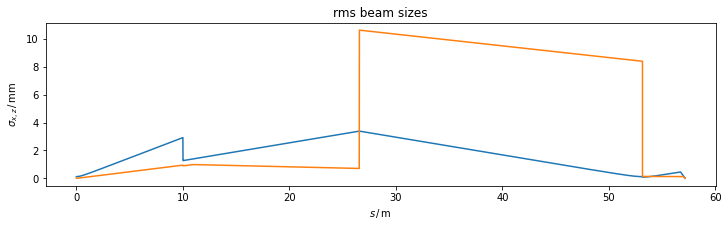

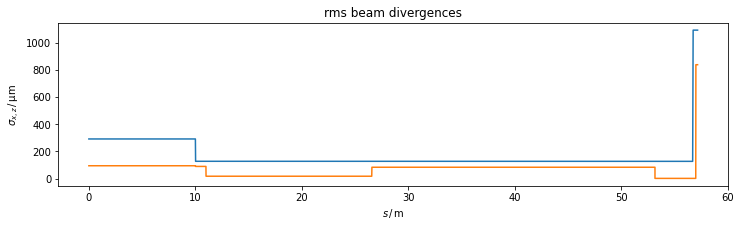

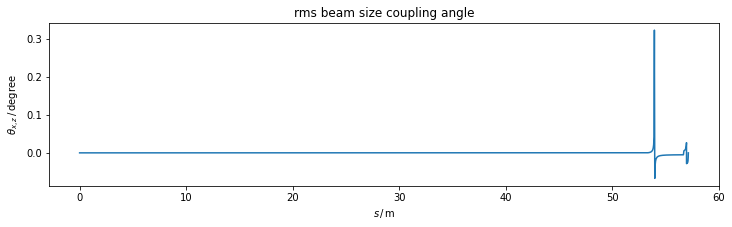

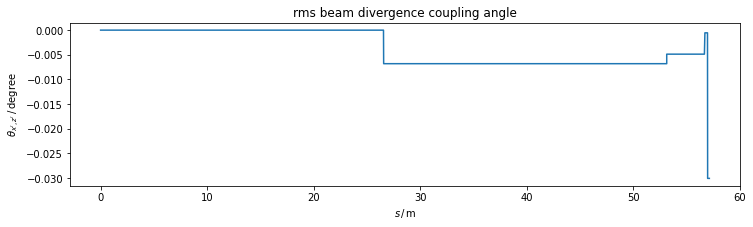

In [6]:
beam_stats = pkjson.load_any(pkio.py_path('beam_stats.json'))
degree = 180 / numpy.pi

x  = beam_stats.s

plt.figure(figsize=(12,3))
plt.title("rms beam sizes")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\sigma_{x,z}\,/\,\mathrm{mm}$')
plt.plot(x, numpy.array(beam_stats.sigmax) * 1e3, label=r'$\sigma_x$')
plt.plot(x, numpy.array(beam_stats.sigmaz) * 1e3, label=r'$\sigma_z$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam divergences")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\sigma_{x,z}\,/\,\mathrm{\mu{m}}$')
plt.plot(x, numpy.array(beam_stats.sigdix) * 1e6, label=r'$\sigma_x$')
plt.plot(x, numpy.array(beam_stats.sigdiz) * 1e6, label=r'$\sigma_z$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam size coupling angle")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\theta_{x,z}\,/\,\mathrm{degree}$')
plt.plot(x, numpy.array(beam_stats.angxz) * degree, label=r'$\theta_{x,z}$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam divergence coupling angle")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\theta_{x^\prime,z^\prime}\,/\,\mathrm{degree}$')
plt.plot(x, numpy.array(beam_stats.angxpzp) * degree, label=r'$\theta_{x\prime,z\prime}$')
plt.show()